In [2]:
# Importar librarias utilizadas

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import Dataset

from datetime import datetime, timedelta

from copy import deepcopy as dc 

from torch.utils.data import DataLoader



In [3]:
# Definir intervalo de tempo utilizado

# Sets the time of the events // Apenas quero uma semana
# Alterar timedelta para alterar linha temporal

current_time = datetime.now() # Data de hoje
seven_days_ago = current_time - timedelta(days=7) # data da semana passada

# Colocar no formato indicado
seven_days_ago = seven_days_ago.strftime("%Y-%m-%d") # Colocar no formato Ano-Mês-Dia
current_time = current_time.date().strftime("%Y-%m-%d") # Colocar no formato Ano-Mês-Dia

In [4]:
# Utilizar yfinance para recolher os dados da Apple consoante a timeline dada
#data = yf.download("AAPL", start=seven_days_ago, end=current_time)

data = yf.download(tickers='AAPL',start=seven_days_ago, end=current_time, \
                   period="1wk", interval="1m") # Desnecessário usar o start= , end= \
                    # Pois com o period= e interval= ele já sabe, mas por data fixa para estudo
                    # Apenas para manter os dados consistentes na pesquisa 


data.reset_index(inplace=True) # Reajusta a tabela para a 'Datetime' ficar no sítio

# Caso o DataFrame tenha um MultiIndex, que é o caso, remover os níveis extras
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # Remove o primeiro nível do índice

# Apenas ver Datetime e Close Price
data = data[['Datetime', 'Close']] # Datetime em vez de Date, pois é em minutos e não dias

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Datetime,Close
0,2025-02-20 14:30:00+00:00,245.970001
1,2025-02-20 14:31:00+00:00,246.389999
2,2025-02-20 14:32:00+00:00,245.889999
3,2025-02-20 14:33:00+00:00,245.400101
4,2025-02-20 14:34:00+00:00,245.710007
...,...,...
1941,2025-02-26 20:55:00+00:00,240.410004
1942,2025-02-26 20:56:00+00:00,240.179993
1943,2025-02-26 20:57:00+00:00,240.149994
1944,2025-02-26 20:58:00+00:00,240.070007


In [5]:
# Diz para usar GPU caso exista, se não existir, usar CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

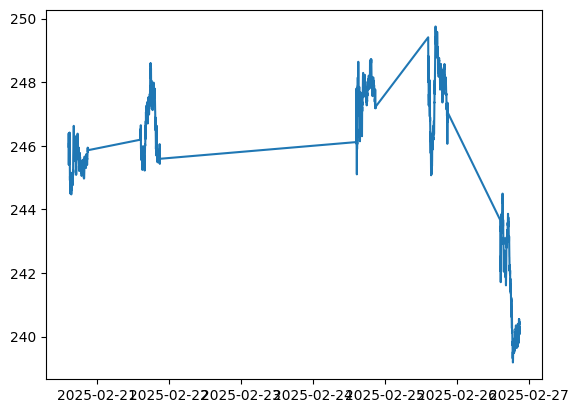

In [6]:
# Fazer o plot do gráfico

plt.plot(data['Datetime'], data['Close'])

In [7]:
#####################################################################
#   TER EM CONTA QUE HÁ PONTOS ONDE O INTERVALO DE TEMPO É MAIOR    #
#   ISTO ACONTECE QUANDO O MERCADO FECHA!                           #
#####################################################################

In [8]:
# Copiar os closings prices da hora anterior, minuto a minuto e associa-os à hora mais recente
# Como é de minuto a minuto, ao ter n steps = 60, copiamos uma hora atrás
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Datetime', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df
# 60 minutos para copiar uma hora
lookback = 60
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-51),Close(t-52),Close(t-53),Close(t-54),Close(t-55),Close(t-56),Close(t-57),Close(t-58),Close(t-59),Close(t-60)
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-20 15:30:00+00:00,244.610001,244.744995,244.850006,244.690002,244.639999,244.554993,244.779999,244.470001,244.914993,244.985001,...,246.100098,245.720001,246.089996,246.009995,246.059998,245.710007,245.400101,245.889999,246.389999,245.970001
2025-02-20 15:31:00+00:00,244.869995,244.610001,244.744995,244.850006,244.690002,244.639999,244.554993,244.779999,244.470001,244.914993,...,246.054001,246.100098,245.720001,246.089996,246.009995,246.059998,245.710007,245.400101,245.889999,246.389999
2025-02-20 15:32:00+00:00,245.089996,244.869995,244.610001,244.744995,244.850006,244.690002,244.639999,244.554993,244.779999,244.470001,...,246.059998,246.054001,246.100098,245.720001,246.089996,246.009995,246.059998,245.710007,245.400101,245.889999
2025-02-20 15:33:00+00:00,245.050003,245.089996,244.869995,244.610001,244.744995,244.850006,244.690002,244.639999,244.554993,244.779999,...,246.240005,246.059998,246.054001,246.100098,245.720001,246.089996,246.009995,246.059998,245.710007,245.400101
2025-02-20 15:34:00+00:00,244.979996,245.050003,245.089996,244.869995,244.610001,244.744995,244.850006,244.690002,244.639999,244.554993,...,246.220001,246.240005,246.059998,246.054001,246.100098,245.720001,246.089996,246.009995,246.059998,245.710007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26 20:55:00+00:00,240.410004,240.475006,240.375000,240.509995,240.479996,240.550003,240.375000,240.550003,240.536301,240.440002,...,239.660004,239.720001,239.639893,239.740005,239.669998,239.720001,239.679993,239.735001,239.960007,240.179993
2025-02-26 20:56:00+00:00,240.179993,240.410004,240.475006,240.375000,240.509995,240.479996,240.550003,240.375000,240.550003,240.536301,...,239.710007,239.660004,239.720001,239.639893,239.740005,239.669998,239.720001,239.679993,239.735001,239.960007
2025-02-26 20:57:00+00:00,240.149994,240.179993,240.410004,240.475006,240.375000,240.509995,240.479996,240.550003,240.375000,240.550003,...,239.839996,239.710007,239.660004,239.720001,239.639893,239.740005,239.669998,239.720001,239.679993,239.735001


In [9]:
# Colocar valores do dataframe em array de numpy (shifted_df_as_np)
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[244.61000061, 244.74499512, 244.8500061 , ..., 245.88999939,
        246.38999939, 245.97000122],
       [244.86999512, 244.61000061, 244.74499512, ..., 245.40010071,
        245.88999939, 246.38999939],
       [245.08999634, 244.86999512, 244.61000061, ..., 245.71000671,
        245.40010071, 245.88999939],
       ...,
       [240.1499939 , 240.17999268, 240.41000366, ..., 239.72000122,
        239.67999268, 239.73500061],
       [240.07000732, 240.1499939 , 240.17999268, ..., 239.66999817,
        239.72000122, 239.67999268],
       [240.30999756, 240.07000732, 240.1499939 , ..., 239.74000549,
        239.66999817, 239.72000122]])

In [10]:
# Colocar shifted_df_as_np em valores que o computador entenda, valores ente -1 e 1, usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.0269762 ,  0.05253124,  0.07241027, ...,  0.26928543,
         0.36393756,  0.28443012],
       [ 0.07619427,  0.0269762 ,  0.05253124, ...,  0.17654552,
         0.26928543,  0.36393756],
       [ 0.11784144,  0.07619427,  0.0269762 , ...,  0.23521205,
         0.17654552,  0.26928543],
       ...,
       [-0.81732208, -0.81164318, -0.76810112, ..., -0.89872153,
        -0.90629531, -0.89588208],
       [-0.83246388, -0.81732208, -0.81164318, ..., -0.90818732,
        -0.89872153, -0.90629531],
       [-0.7870327 , -0.83246388, -0.81732208, ..., -0.89493463,
        -0.90818732, -0.89872153]])

In [11]:
# Separar variáveis independentes (x) e variável alvo (y)
# x são todos os preços na hora anterior a cada elemento de y e y é a lista de closing prices
x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape

((1886, 60), (1886,))

In [12]:
# Inverter a ordem dos passos de tempo
# Senão ele estaria a fazer do recente para o antigo e não ao contrário
# o que iria distorcer os resultados
x = dc(np.flip(x, axis=1))
x

array([[ 0.28443012,  0.36393756,  0.26928543, ...,  0.04212089,
         0.07241027,  0.05253124],
       [ 0.36393756,  0.26928543,  0.17654552, ...,  0.07241027,
         0.05253124,  0.0269762 ],
       [ 0.26928543,  0.17654552,  0.23521205, ...,  0.05253124,
         0.0269762 ,  0.07619427],
       ...,
       [-0.89588208, -0.90629531, -0.89872153, ..., -0.75579588,
        -0.76810112, -0.81164318],
       [-0.90629531, -0.89872153, -0.90818732, ..., -0.76810112,
        -0.81164318, -0.81732208],
       [-0.89872153, -0.90818732, -0.89493463, ..., -0.81164318,
        -0.81732208, -0.83246388]])

In [13]:
# Ver quantos dados dados de treino (90%) e de teste (10%)
split_index = int(len(x) * 0.9)
split_index

1697

In [14]:
# Separar os dados em treino (90%) e teste (10%)

x_train = x[:split_index]   # x de 0 a 90%
x_test = x[split_index:]    # x de 90% a 100%

y_train =y[:split_index]    # y de 0 a 90%
y_test = y[split_index:]    # y de 90% a 100%

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1697, 60), (189, 60), (1697,), (189,))

In [15]:
# Reformatar para entrada no modelo (batch_size, sequência, features)

x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1697, 60, 1), (189, 60, 1), (1697, 1), (189, 1))

In [16]:
# Converter arrays NumPy para tensores PyTorch

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1697, 60, 1]),
 torch.Size([189, 60, 1]),
 torch.Size([1697, 1]),
 torch.Size([189, 1]))

In [17]:
# Criar classe de dataset para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)


In [18]:
# Criar DataLoaders para treino e teste

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Testar forma dos batches de treino
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 60, 1]) torch.Size([32, 1])


In [20]:
# Definir modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 100, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
# Função para treinar uma época de dados
def train_one_epoch():
    model.train(True)  # Set model to training mode
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    # Iterate through batches in the training set
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)  # Forward pass
        loss = loss_function(output, y_batch)  # Compute loss
        running_loss += loss.item()

        optimizer.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Print loss every 100 batches
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [22]:
# Function to validate the model after each epoch
def validate_one_epoch():
    model.train(False)  # Set model to evaluation mode
    running_loss = 0.0

    # Iterate through batches in the test set
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():  # Disable gradient calculation for validation
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [23]:
# Set learning parameters
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [24]:
# Train and validate model
for epoch in range(num_epochs):
    train_one_epoch()
    val_loss = validate_one_epoch()
    if val_loss is not None:
        scheduler.step(val_loss)

Epoch: 1

Val Loss: 0.007
***************************************************

Epoch: 2

Val Loss: 0.027
***************************************************

Epoch: 3

Val Loss: 0.011
***************************************************

Epoch: 4

Val Loss: 0.002
***************************************************

Epoch: 5

Val Loss: 0.003
***************************************************

Epoch: 6

Val Loss: 0.002
***************************************************

Epoch: 7

Val Loss: 0.001
***************************************************

Epoch: 8

Val Loss: 0.002
***************************************************

Epoch: 9

Val Loss: 0.008
***************************************************

Epoch: 10

Val Loss: 0.001
***************************************************

Epoch: 11

Val Loss: 0.004
***************************************************

Epoch: 12

Val Loss: 0.001
***************************************************

Epoch: 13

Val Loss: 0.003
**********************

In [25]:
print(y_train)

tensor([[ 0.0270],
        [ 0.0762],
        [ 0.1178],
        ...,
        [-0.4671],
        [-0.4747],
        [-0.4520]])


In [26]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

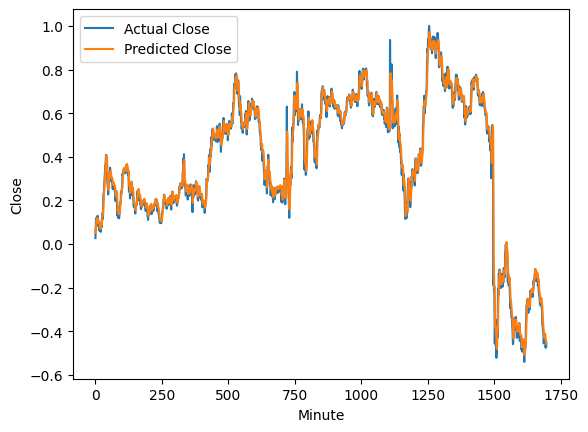

In [27]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([244.80908112, 244.73444908, 244.81579586, ..., 242.11046556,
       242.07692303, 242.04903795])

In [29]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/tmp/ipykernel_1728/2743067881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([244.61000061, 244.86999511, 245.08999636, ..., 241.99999998,
       241.96000673, 242.08000191])

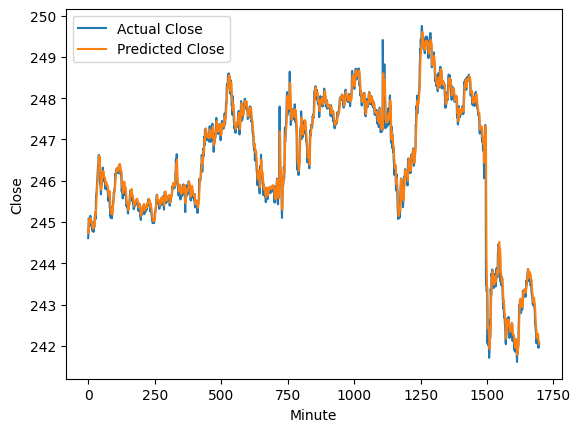

In [30]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [31]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([242.09292651, 242.01738019, 241.82310963, 241.81009766,
       241.84743898, 241.87542514, 241.74188352, 241.61461362,
       241.61808434, 241.62467408, 241.6718605 , 241.6329562 ,
       241.60093068, 241.52438909, 241.50336515, 241.50245457,
       241.47285317, 241.34276274, 241.26921516, 241.21984675,
       241.23221483, 241.22306117, 241.13356995, 241.0751055 ,
       241.18143175, 241.11517762, 241.06103433, 241.02690396,
       240.91870272, 240.86440987, 240.79373824, 240.88704244,
       240.92082614, 240.90460353, 240.84108902, 240.7149712 ,
       240.54946892, 240.64699856, 240.63905838, 240.56329575,
       240.49545661, 240.37635423, 240.35368325, 240.32937278,
       240.30150658, 240.18821214, 240.07613809, 239.98144724,
       239.98071582, 239.86663232, 239.79264835, 239.74594272,
       239.6362229 , 239.60173862, 239.63273045, 239.67718702,
       239.56252765, 239.51269954, 239.48224927, 239.52775181,
       239.64081484, 239.75166092, 239.79490622, 239.85

In [32]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_1728/973696869.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([241.85000605, 241.55499269, 241.77999878, 241.8200073 ,
       241.8200073 , 241.50500495, 241.42999263, 241.58000183,
       241.55000308, 241.63999934, 241.48989883, 241.49000557,
       241.36000047, 241.41499325, 241.41990667, 241.35000613,
       241.11000067, 241.13000477, 241.08999625, 241.16499314,
       241.11000067, 240.92999271, 240.92999271, 241.22000135,
       240.89999396, 240.91000372, 240.89500434, 240.69000236,
       240.72000111, 240.61000075, 240.90359503, 240.81500242,
       240.75599672, 240.64999384, 240.46000666, 240.2599946 ,
       240.69000236, 240.47000131, 240.34030163, 240.30000312,
       240.11000051, 240.22000119, 240.16000368, 240.12499989,
       239.8999938 , 239.80990591, 239.72999561, 239.83999629,
       239.54200749, 239.55000308, 239.51989759, 239.30999762,
       239.38999954, 239.47999581, 239.52000433, 239.18499756,
       239.27000421, 239.23989872, 239.38000489, 239.55999742,
       239.649994  , 239.61000059, 239.71000662, 239.92

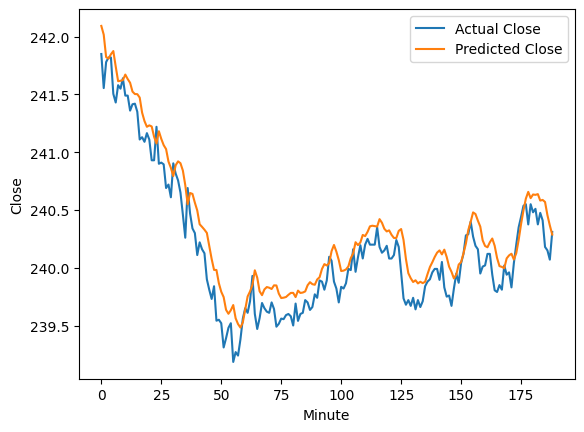

In [33]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()

In [34]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions


dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_1728/2457523599.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([241.85000605, 241.55499269, 241.77999878, 241.8200073 ,
       241.8200073 , 241.50500495, 241.42999263, 241.58000183,
       241.55000308, 241.63999934, 241.48989883, 241.49000557,
       241.36000047, 241.41499325, 241.41990667, 241.35000613,
       241.11000067, 241.13000477, 241.08999625, 241.16499314,
       241.11000067, 240.92999271, 240.92999271, 241.22000135,
       240.89999396, 240.91000372, 240.89500434, 240.69000236,
       240.72000111, 240.61000075, 240.90359503, 240.81500242,
       240.75599672, 240.64999384, 240.46000666, 240.2599946 ,
       240.69000236, 240.47000131, 240.34030163, 240.30000312,
       240.11000051, 240.22000119, 240.16000368, 240.12499989,
       239.8999938 , 239.80990591, 239.72999561, 239.83999629,
       239.54200749, 239.55000308, 239.51989759, 239.30999762,
       239.38999954, 239.47999581, 239.52000433, 239.18499756,
       239.27000421, 239.23989872, 239.38000489, 239.55999742,
       239.649994  , 239.61000059, 239.71000662, 239.92

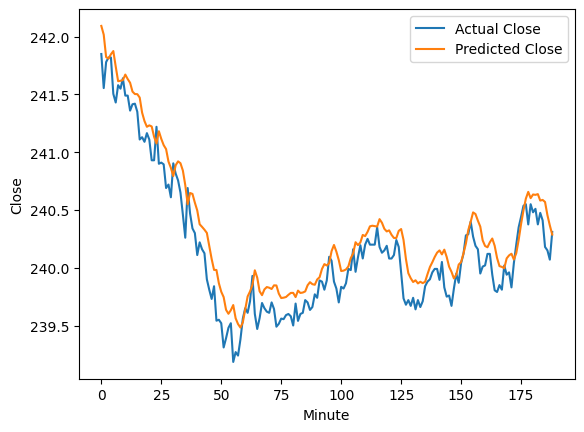

In [35]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Close')
plt.legend()
plt.show()


In [36]:
##############################
# Tentar implementar as news #
##############################

In [37]:
stock_symbol = "AAPL"  # Pode ser qualquer ação
ticker = yf.Ticker(stock_symbol)


# Recebe as 10 notícias mais recentes
news = ticker.news 


for article in news:
    if (int(article['content']['pubDate'][8:10]) == datetime.today().day \
    or int(article['content']['pubDate'][8:10]) == datetime.today().day - 1) \
    and int(article['content']['pubDate'][5:7]) == datetime.today().month \
    and int(article['content']['pubDate'][:4]) == datetime.today().year:
        print(f"Data publicação: {article['content']['pubDate']}")
        print(f"Título: {article['content']['title']}")
        print(article['content']['summary'])
        print(f"URL: {article['content']['canonicalUrl']['url']}")

    print("-" * 50)

#ticker.actions
#ticker.financials

Data publicação: 2025-02-27T02:00:55Z
Título: Apple iPhone 16e: What it's like to use Apple's newest budget-friendly iPhone
Apple's budget-friendly iPhone 16e hits stores Friday and packs a number of features you'll find on the company's high-end phones — and one you won't.
URL: https://finance.yahoo.com/news/apple-iphone-16e-what-its-like-to-use-apples-newest-budget-friendly-iphone-020055387.html
--------------------------------------------------
Data publicação: 2025-02-26T16:53:31Z
Título: BofA and BlackRock pare 'diversity' from reports as Wall Street's DEI retreat mounts
Bank of America and BlackRock are scrapping mentions of diversity from their annual reports as scrutiny of DEI policies intensifies across Wall Street.
URL: https://finance.yahoo.com/news/bofa-and-blackrock-pare-diversity-from-reports-as-wall-streets-dei-retreat-mounts-165331457.html
--------------------------------------------------
--------------------------------------------------
Data publicação: 2025-02-26T11

In [38]:
# Criar um DataFrame com as notícias e datas
news_data = []
for article in news:
    display_time = article['content'].get('displayTime', '')  # Evita KeyError
    try:
        date_parsed = datetime.strptime(display_time, "%Y-%m-%dT%H:%M:%SZ") if display_time else None
    except ValueError:
        date_parsed = None  # Caso a string tenha um formato inválido
    if date_parsed != None:
        news_data.append({
            "title": article['content']["title"],
            "link": article['content']['canonicalUrl']['url'],
            "content": article['content']['summary'],
            "date": date_parsed,  # Converter string para datetime
            "publisher": article['content']['provider']['displayName']
        })

news_df = pd.DataFrame(news_data)
print(news_df.head())
news_df


                                               title  \
0  Apple iPhone 16e: What it's like to use Apple'...   
1  BofA and BlackRock pare 'diversity' from repor...   
2  Trump asks Apple to drop diversity policies af...   
3  Nvidia's post-earnings reactions don't always ...   
4  1 Spectacular Vanguard ETF to Buy With $420 Du...   

                                                link  \
0  https://finance.yahoo.com/news/apple-iphone-16...   
1  https://finance.yahoo.com/news/bofa-and-blackr...   
2  https://finance.yahoo.com/news/trump-asks-appl...   
3  https://finance.yahoo.com/news/nvidias-post-ea...   
4  https://www.fool.com/investing/2025/02/27/1-va...   

                                             content                date  \
0  Apple's budget-friendly iPhone 16e hits stores... 2025-02-27 02:00:55   
1  Bank of America and BlackRock are scrapping me... 2025-02-26 16:53:31   
2  President Donald Trump urged Apple to 'get rid... 2025-02-26 14:52:38   
3  Markets await Nvidi

,title,link,content,date,publisher
0,Apple iPhone 16e: What it's like to use Apple'...,https://finance.yahoo.com/news/apple-iphone-16...,Apple's budget-friendly iPhone 16e hits stores...,2025-02-27 02:00:55,Yahoo Finance
1,BofA and BlackRock pare 'diversity' from repor...,https://finance.yahoo.com/news/bofa-and-blackr...,Bank of America and BlackRock are scrapping me...,2025-02-26 16:53:31,Yahoo Finance
2,Trump asks Apple to drop diversity policies af...,https://finance.yahoo.com/news/trump-asks-appl...,President Donald Trump urged Apple to 'get rid...,2025-02-26 14:52:38,Yahoo Finance
3,Nvidia's post-earnings reactions don't always ...,https://finance.yahoo.com/news/nvidias-post-ea...,Markets await Nvidia's quarterly results with ...,2025-02-26 11:00:14,Yahoo Finance
4,1 Spectacular Vanguard ETF to Buy With $420 Du...,https://www.fool.com/investing/2025/02/27/1-va...,The S&P 500 (SNPINDEX: ^GSPC) is made up of 50...,2025-02-27 09:22:00,Motley Fool
5,Apple Inc. (AAPL) Unveils $500 Billion U.S. In...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently compiled a list of the 10 Hot AI S...,2025-02-27 06:02:11,Insider Monkey
6,"Indonesia, Apple Reach Investment Agreement, P...",https://www.wsj.com/tech/indonesia-apple-reach...,Apple has reached an investment agreement with...,2025-02-27 04:57:00,The Wall Street Journal
7,Apple blames name-calling glitch on its new AI...,https://www.thestreet.com/technology/apple-rep...,This isn't the first time that Apple Intellige...,2025-02-27 03:07:00,TheStreet
8,One Tech Tip: Getting a lot of unwanted phone ...,https://www.yahoo.com/tech/one-tech-tip-gettin...,Unwanted phone calls are out of control. Whet...,2025-02-27 02:21:06,Associated Press Finance
9,The ‘Spy Sheikh’ Taking the AI World by Storm,https://www.wsj.com/tech/ai/abu-dhabi-spy-shei...,Abu Dhabi’s Tahnoon bin Zayed al Nahyan has mo...,2025-02-27 02:00:00,The Wall Street Journal


In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Aplicar análise de sentimento
#news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]) + \
#                        news_df["content"].apply(lambda content: sia.polarity_scores(content)["compound"])) / len(news_df)
news_df["sentiment"] = (news_df["title"].apply(lambda title: sia.polarity_scores(title)["compound"]))
news_df["sentimento_qualitativo"] = "Neutral"
for i in range(news_df.shape[0]):
    if (news_df.loc[i]["sentiment"] >= -0.1) and (news_df.loc[i]["sentiment"] < 0.1):
        news_df["sentimento_qualitativo"][i] = "Neutral"
    elif 0.1 < news_df.loc[i]["sentiment"] < 0.5:
        news_df["sentimento_qualitativo"][i] = "Buy"
    elif 0.5 < news_df.loc[i]["sentiment"] <= 1:
        news_df["sentimento_qualitativo"][i] = "Strong Buy"
    elif -0.5 <= news_df.loc[i]["sentiment"] < -0.1:
        news_df["sentimento_qualitativo"][i] = "Sell"
    elif -1 <= news_df.loc[i]["sentiment"] < -0.5:
        news_df["sentimento_qualitativo"][i] = "Strong Sell"


#print(news_df[["title", "content", "sentiment"]].head())
#sum(news_df['sentiment'])
news_df



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_1728/3109798963.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  news

,title,link,content,date,publisher,sentiment,sentimento_qualitativo
0,Apple iPhone 16e: What it's like to use Apple'...,https://finance.yahoo.com/news/apple-iphone-16...,Apple's budget-friendly iPhone 16e hits stores...,2025-02-27 02:00:55,Yahoo Finance,0.3612,Buy
1,BofA and BlackRock pare 'diversity' from repor...,https://finance.yahoo.com/news/bofa-and-blackr...,Bank of America and BlackRock are scrapping me...,2025-02-26 16:53:31,Yahoo Finance,0.2023,Buy
2,Trump asks Apple to drop diversity policies af...,https://finance.yahoo.com/news/trump-asks-appl...,President Donald Trump urged Apple to 'get rid...,2025-02-26 14:52:38,Yahoo Finance,-0.2732,Sell
3,Nvidia's post-earnings reactions don't always ...,https://finance.yahoo.com/news/nvidias-post-ea...,Markets await Nvidia's quarterly results with ...,2025-02-26 11:00:14,Yahoo Finance,0.0000,Neutral
4,1 Spectacular Vanguard ETF to Buy With $420 Du...,https://www.fool.com/investing/2025/02/27/1-va...,The S&P 500 (SNPINDEX: ^GSPC) is made up of 50...,2025-02-27 09:22:00,Motley Fool,0.0000,Neutral
5,Apple Inc. (AAPL) Unveils $500 Billion U.S. In...,https://finance.yahoo.com/news/apple-inc-aapl-...,We recently compiled a list of the 10 Hot AI S...,2025-02-27 06:02:11,Insider Monkey,0.4019,Buy
6,"Indonesia, Apple Reach Investment Agreement, P...",https://www.wsj.com/tech/indonesia-apple-reach...,Apple has reached an investment agreement with...,2025-02-27 04:57:00,The Wall Street Journal,-0.0772,Neutral
7,Apple blames name-calling glitch on its new AI...,https://www.thestreet.com/technology/apple-rep...,This isn't the first time that Apple Intellige...,2025-02-27 03:07:00,TheStreet,-0.4019,Sell
8,One Tech Tip: Getting a lot of unwanted phone ...,https://www.yahoo.com/tech/one-tech-tip-gettin...,Unwanted phone calls are out of control. Whet...,2025-02-27 02:21:06,Associated Press Finance,-0.4767,Sell
9,The ‘Spy Sheikh’ Taking the AI World by Storm,https://www.wsj.com/tech/ai/abu-dhabi-spy-shei...,Abu Dhabi’s Tahnoon bin Zayed al Nahyan has mo...,2025-02-27 02:00:00,The Wall Street Journal,0.0000,Neutral


In [43]:
# Arredondar a data para remover horas e minutos
news_df["date"] = news_df["date"].dt.date

# Arredondar também no dataset de preços
data["Datetime"] = data["Datetime"].dt.date

# Calcular sentimento médio por dia
daily_sentiment = news_df.groupby("date")["sentiment"].mean()

# Adicionar sentimento ao dataset de preços
data = data.merge(daily_sentiment, left_on="Date", right_index=True, how="left")

# Preencher valores ausentes com 0 (caso não tenha notícias em um dia)
data["sentiment"].fillna(0, inplace=True)

print(data.head())
data

AttributeError: Can only use .dt accessor with datetimelike values